In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor, Ridge
from sklearn.inspection import permutation_importance
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Separate features and target
X = train.drop('yield', axis=1)
y = train['yield']

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1)),
    ('ridge', Ridge(alpha=0.40712299476079644, max_iter=1000, random_state=42))
])


# Define the random forest regressor
random_forest = RandomForestRegressor(
    n_estimators=448,
    max_depth=13,
    min_samples_split=15,
    min_samples_leaf=10,
    max_features=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Define stacking regressor
stacking_reg = StackingRegressor(
    estimators=[
        ('linear', logistic_pipeline),
        ('random_forest', random_forest)
    ],
    final_estimator=Ridge(alpha=0.40712299476079644, random_state=42, max_iter=1000),  # Increase alpha if needed
    cv=5
)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit stacking model
stacking_reg.fit(X_train, y_train)

# Predictions
y_pred = stacking_reg.predict(X_test)
y_pred_train = stacking_reg.predict(X_train)

# Calculate Mean Absolute Error (MAE) for test and training sets
MAE_test = mean_absolute_error(y_test, y_pred)
MAE_train = mean_absolute_error(y_train, y_pred_train)
print("Test MAE:", MAE_test)
print("Train MAE:", MAE_train)

Test MAE: 244.0742077135613
Train MAE: 207.39578790328534


### There is a overfitting.

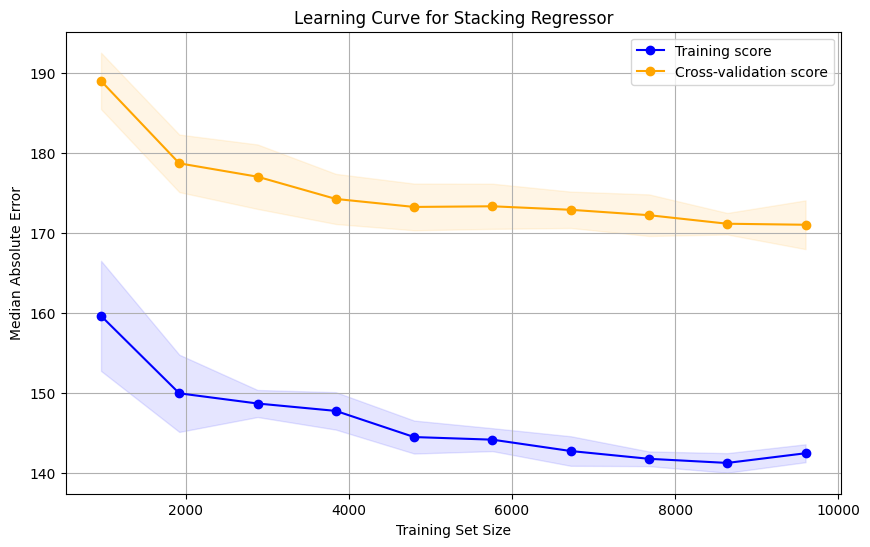

In [5]:
# Parameters for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    stacking_reg, X_train, y_train, cv=5, scoring="neg_median_absolute_error", train_sizes=train_sizes, n_jobs=-1
)

# Convert negative scores to positive median absolute error values
train_scores = -train_scores
test_scores = -test_scores

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="orange", label="Cross-validation score")

# Fill in the standard deviation areas
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.1)

# Add labels and title
plt.xlabel("Training Set Size")
plt.ylabel("Median Absolute Error")
plt.title("Learning Curve for Stacking Regressor")
plt.legend(loc="best")
plt.grid()
plt.show()


In [ ]:
y_pred_test = stacking_reg.predict(test)

In [ ]:
subm = pd.read_csv("sample_submission.csv")
subm['yield'] = y_pred_test
subm.to_csv("my_submission_1.csv", index=False)